# Final

## In this milestone:
1. Models:
- K-Means with different parameters
- k-medoids
- AgglomerativeClustering (linkage = ["single", "complete, "average", "centroid, "ward"])
- DBSCAN with different eps, min_samples, metric
- GMM
2. PCA/TSNE

## Importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
import sklearn
import seaborn as sns

np.random.seed = 42

df=pd.read_csv('../data/for_modellers/after_scaling.csv')

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
seed=42

It was compiling all night and still nothing, so we'll work on smaller samples.

In [3]:
sample_df = df.sample(n=10000, random_state=42)

## 1. KMeans

### 1.1 eps

In [4]:
def count_wcss_scores(X, k_max):
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=seed)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1
        scores.append(wcss)
    return scores

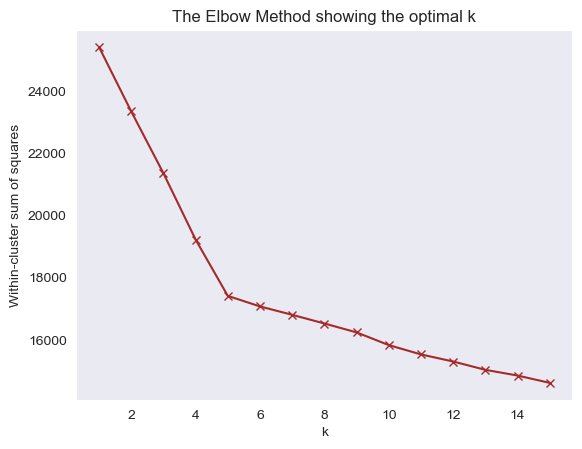

In [17]:
wcss_vec = count_wcss_scores(sample_df, 15)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'x-', color = "brown")
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.grid()
plt.show()

In [9]:
from sklearn.metrics import silhouette_score
def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k, random_state = seed)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

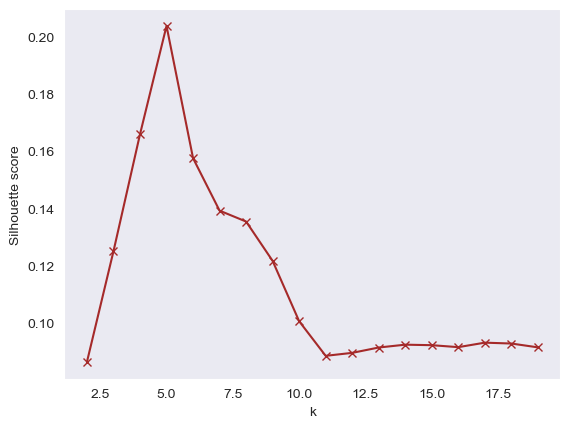

In [19]:
cluster_num_seq = range(2, 20)
silhouette_vec = count_clustering_scores(sample_df, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'x-', color = "brown")
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.grid()
plt.show()

In [20]:
def metrics_plots(df,max_k=20):

    score = []

    score_kmeans_c = []
    score_kmeans_d = []

    for k in range(2, max_k):
        kmeans = KMeans(n_clusters=k, random_state= 101)
        predictions = kmeans.fit_predict(df)
        score.append(kmeans.score(df))
        score_kmeans_c.append(calinski_harabasz_score(df, kmeans.labels_))
        score_kmeans_d.append(davies_bouldin_score(df, predictions))

    list_scores = [score, score_kmeans_c, score_kmeans_d] 
    list_title = ['Within-cluster sum of squares', 'Calinski Harabasz', 'Davies Bouldin'] 
    for i in range(len(list_scores)):
        x_ticks = list(range(2, len(list_scores[i]) + 2))
        plt.plot(x_ticks, list_scores[i], 'bx-')
        plt.xlabel('k')
        plt.ylabel(list_title[i])
        plt.title('Optimal k')
        plt.show()

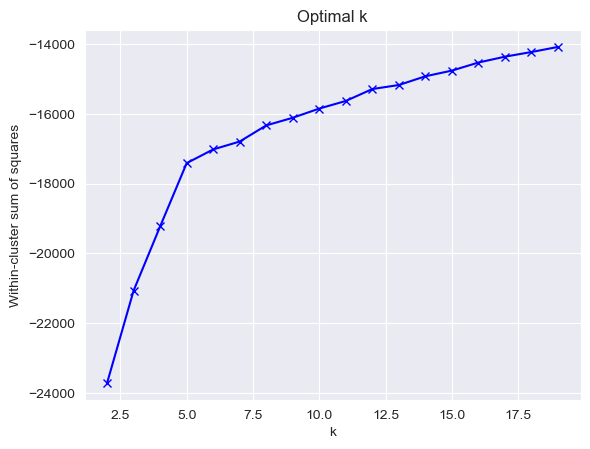

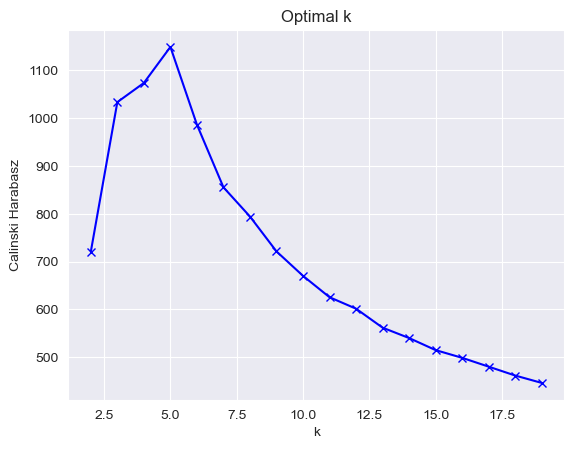

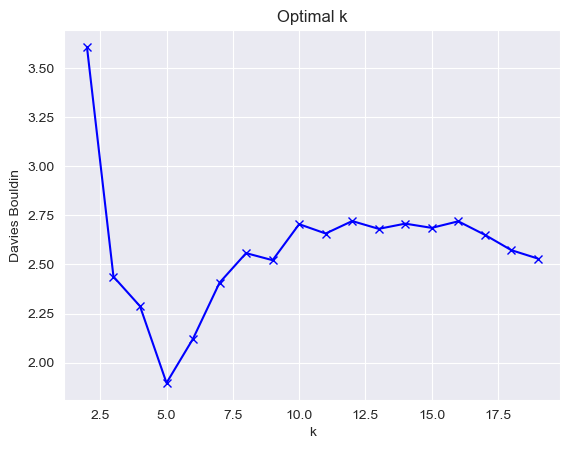

In [21]:
metrics_plots(sample_df,20)

According to all metrics, we should have n_clusters=5.

### 1.2 different parameters

In [22]:
def evaluate_kmeans(X, init_methods, algorithms):
    results = []

    for alg in algorithms:
        for init in init_methods:
            kmeans = KMeans(n_clusters=5, init=init, algorithm = alg, random_state=42)
            labels = kmeans.fit_predict(X)

            inertia = kmeans.inertia_
            ch_score = calinski_harabasz_score(X, labels)
            db_score = davies_bouldin_score(X, labels)
            silhouette_avg = silhouette_score(X, labels)

            results.append({
                'algorithm': alg,
                'init': init,
                'inertia': inertia,
                'calinski_harabasz': ch_score,
                'davies_bouldin': db_score,
                'silhouette': silhouette_avg
            })

    return results

init_methods = ['k-means++', 'random']
algorithms = ['lloyd', 'elkan']

results = evaluate_kmeans(sample_df, init_methods, algorithms)

import pandas as pd

results_df = pd.DataFrame(results)
print(results_df)


  algorithm       init       inertia  calinski_harabasz  davies_bouldin  \
0     lloyd  k-means++  17414.687779        1149.033353        1.895746   
1     lloyd     random  17414.679444        1149.034479        1.897294   
2     elkan  k-means++  17414.687779        1149.033353        1.895746   
3     elkan     random  17414.679444        1149.034479        1.897294   

   silhouette  
0    0.203611  
1    0.203618  
2    0.203611  
3    0.203618  


algorithm doesn't change scores, kmeans++ and random give similar scores too. Chosen parameters for K-Means: n_clusters=5, init="k_means++" 

## 2. K-medoids

In [10]:
import sklearn_extra

In [28]:
from sklearn_extra.cluster import KMedoids

In [29]:
def plot_kmedoids_clusters(X, n_clusters):
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=0)
    kmedoids.fit(X)
    y_kmedoids = kmedoids.predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=y_kmedoids, s=30, cmap='viridis')

    centers = kmedoids.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
    plt.title('K-medoids clusters')
    plt.show()

Takes too long to execute:

In [30]:
def metrics_plots_medoids(df, max_k=20):

    score_kmedoids_c = []
    score_kmedoids_d = []

    for k in range(2, max_k):
        kmedoids = KMedoids(n_clusters=k, random_state=101)
        predictions = kmedoids.fit_predict(df)
        score_kmedoids_c.append(calinski_harabasz_score(df, kmedoids.labels_))
        score_kmedoids_d.append(davies_bouldin_score(df, predictions))

    list_scores = [score_kmedoids_c, score_kmedoids_d] 
    list_title = ['Calinski Harabasz', 'Davies Bouldin'] 

    for i in range(len(list_scores)):
        x_ticks = list(range(2, len(list_scores[i]) + 2))
        plt.plot(x_ticks, list_scores[i], 'bx-')
        plt.xlabel('k')
        plt.ylabel(list_title[i])
        plt.title('Optimal k')
        plt.show()

In [32]:
kmedoids = KMedoids(n_clusters=5, random_state=42)
predictions = kmedoids.fit_predict(sample_df)
print(silhouette_score(sample_df, predictions))

0.06184439670426957


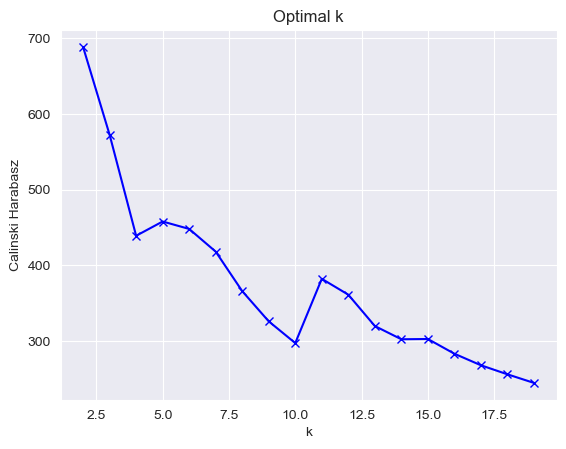

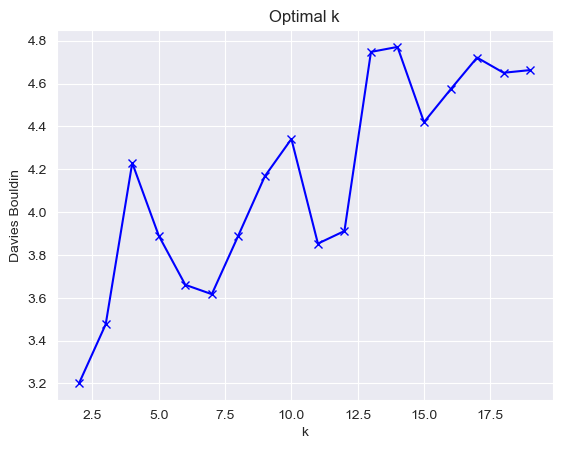

In [34]:
metrics_plots_medoids(sample_df)

the best parameters: n_components=5,7,11,15. Let's use silhouette score

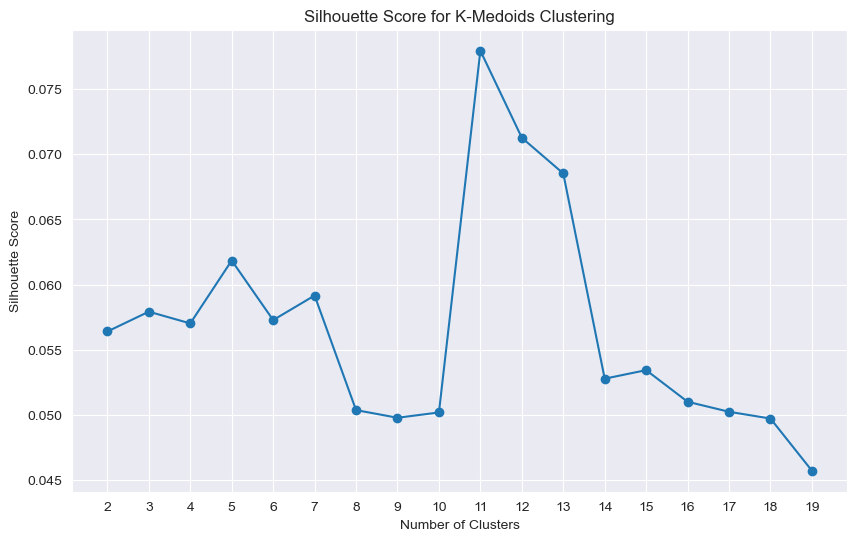

In [35]:
n_clusters_range = range(2, 20)
silhouette_scores = []
for n_clusters in n_clusters_range:
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)
    labels = kmedoids.fit_predict(sample_df)
    score = silhouette_score(sample_df, labels)
    silhouette_scores.append(score)
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for K-Medoids Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(n_clusters_range)
plt.grid(True)
plt.show()



The best n_components=11.

## 1.3 AgglomerativeClustering

In [6]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from matplotlib.ticker import MaxNLocator

In [7]:
linkages = ['ward', 'complete', 'average', 'single']

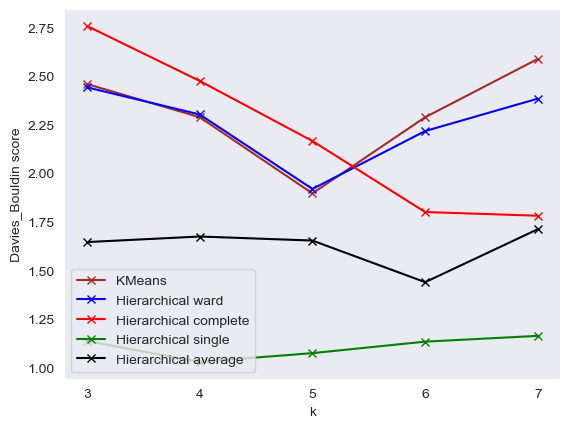

In [10]:
cluster_num_seq = range(3, 8)
davies_vec_kmeans = count_clustering_scores(sample_df, cluster_num_seq, KMeans, davies_bouldin_score)
davies_vec_hierarchical = {'ward': [], 'complete': [], 'average': [], 'single': []}
for linkage in linkages:
    for k in cluster_num_seq:
        model_instance = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = model_instance.fit_predict(sample_df)
        wcss = davies_bouldin_score(sample_df, labels)
        davies_vec_hierarchical[linkage].append(wcss)

ax = plt.figure().gca()
plt.plot(cluster_num_seq, davies_vec_kmeans, 'x-', color = "brown", label="KMeans")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(cluster_num_seq, davies_vec_hierarchical['ward'], 'x-', color = "blue", label="Hierarchical ward")
plt.plot(cluster_num_seq, davies_vec_hierarchical['complete'], 'x-', color = "red", label="Hierarchical complete")
plt.plot(cluster_num_seq, davies_vec_hierarchical['single'], 'x-', color = "green", label="Hierarchical single")
plt.plot(cluster_num_seq, davies_vec_hierarchical['average'], 'x-', color = "black", label="Hierarchical average")
plt.xlabel('k')
plt.ylabel('Davies_Bouldin score')
plt.legend(loc="lower left")
plt.grid()
plt.savefig("output.jpg")
plt.show()

Here the best one is linkage="single" with n_clusters=4 and linkage="average" with k=6.

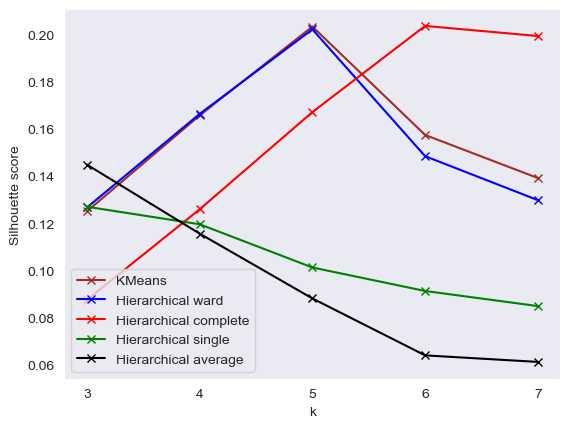

In [11]:
# silhouette_score
cluster_num_seq = range(3, 8)
silhouette_vec_kmeans = count_clustering_scores(sample_df, cluster_num_seq, KMeans, silhouette_score)
silhouette_vec_hierarchical = {'ward': [], 'complete': [], 'average': [], 'single': []}
for linkage in linkages:
    for k in cluster_num_seq:
        model_instance = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = model_instance.fit_predict(sample_df)
        wcss = silhouette_score(sample_df, labels)
        silhouette_vec_hierarchical[linkage].append(wcss)

ax = plt.figure().gca()
plt.plot(cluster_num_seq, silhouette_vec_kmeans, 'x-', color = "brown", label="KMeans")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(cluster_num_seq, silhouette_vec_hierarchical['ward'], 'x-', color = "blue", label="Hierarchical ward")
plt.plot(cluster_num_seq, silhouette_vec_hierarchical['complete'], 'x-', color = "red", label="Hierarchical complete")
plt.plot(cluster_num_seq, silhouette_vec_hierarchical['single'], 'x-', color = "green", label="Hierarchical single")
plt.plot(cluster_num_seq, silhouette_vec_hierarchical['average'], 'x-', color = "black", label="Hierarchical average")
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.legend(loc="lower left")
plt.grid()
plt.savefig("output2.jpg")
plt.show()

According to silhouette score the best are KMeans with k=5 and hierarchical with parameters: linkage=ward and k=5, linkage=complete and k=6(average with k=6 is the worst, it was the best in davies bouldin score)

## 1.4 DBSCAN

In [12]:
from sklearn.cluster import DBSCAN

In [13]:
df.head()

,awayScore,homeScore,matchWeek,aerials_lost,aerials_won,age,assisted_shots,assists,ball_recoveries,blocked_shots,...,middle_schema_away,strikers_schema_away,matchYear,matchMonth,championship_name_bundesliga,championship_name_liga,championship_name_ligue 1,championship_name_premier league,championship_name_seria a,championship_name_unknown
0,0.444444,0.111111,0.918919,0.000000,0.000000,0.321429,0.000,0.0,0.035714,0.0,...,0.333333,0.5,1.0,0.363636,0.0,0.0,0.0,0.0,1.0,0.0
1,0.444444,0.000000,0.459459,0.000000,0.066667,0.178571,0.000,0.0,0.392857,0.0,...,0.666667,0.0,1.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.405405,0.000000,0.066667,0.285714,0.125,0.0,0.357143,0.0,...,0.666667,0.5,1.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0
3,0.222222,0.222222,0.243243,0.000000,0.066667,0.464286,0.000,0.0,0.571429,0.0,...,0.666667,0.0,0.0,0.818182,0.0,0.0,0.0,1.0,0.0,0.0
4,0.000000,0.222222,0.297297,0.157895,0.000000,0.321429,0.000,0.0,0.214286,0.0,...,0.666667,0.0,1.0,0.909091,1.0,0.0,0.0,0.0,0.0,0.0


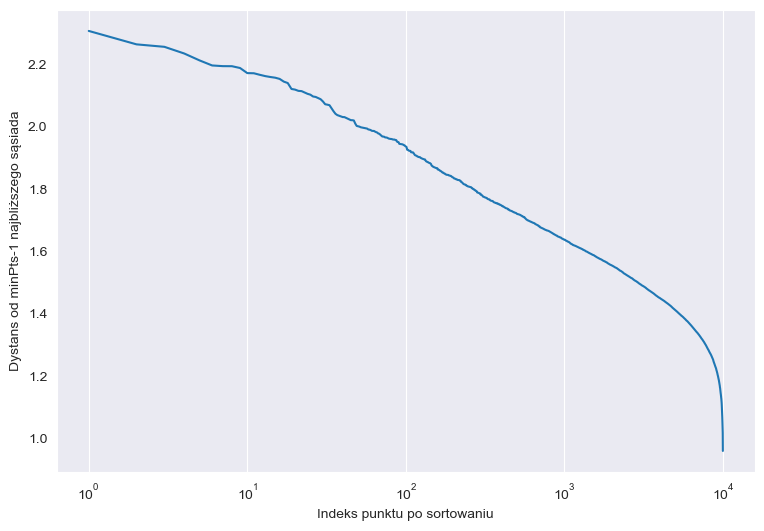

In [16]:
minPts = 162 #2*nr of columns
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=minPts).fit(sample_df)
distances, indices = nbrs.kneighbors(sample_df)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od minPts-1 najbliższego sąsiada')
ax1.plot(list(range(1,sample_df.shape[0]+1)), distanceDec)

plt.xscale('log')
plt.grid(axis='y')

plt.show()

eps = 2.2-2.05 or 1.7-1.9 or 1.2-1.4, let's test which is the best

In [19]:
# List of parameters to test
eps_list = [2.05, 2.1, 2.2, 2.15, 1.7, 1.75, 1.8, 1.85,1.9, 1.2, 1.25, 1.3, 1.35, 1.4]
metric_list = ['euclidean', 'manhattan']
best_score=-1
results = []
for eps in eps_list:
    for metric in metric_list:
        dbscan = DBSCAN(eps=eps, min_samples=162, metric=metric)
        labels = dbscan.fit_predict(sample_df)
        # ignorowanie wynikow z jednym klastrem
        if len(np.unique(labels)) > 1:
            score = silhouette_score(sample_df, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_metric = metric

print(f"Best score: {best_score}, eps: {best_eps}, best_metric: {best_metric}")

Best score: 0.21058798216846472, eps: 1.9, best_metric: euclidean


Let's check Davies-Bouldin score:

In [26]:
# List of parameters to test
eps_list = [2.05, 2.1, 2.2, 2.15, 1.7, 1.75, 1.8, 1.85, 1.9, 1.2, 1.25, 1.3, 1.35, 1.4]
metric_list = ['euclidean', 'manhattan']

best_score = float('inf') 
best_eps = None
best_metric = None

results = []

# Loop through all combinations of eps and metric
for eps in eps_list:
    for metric in metric_list:
        dbscan = DBSCAN(eps=eps, min_samples=162, metric=metric)
        labels = dbscan.fit_predict(sample_df)

        # Ignore results with only one cluster
        if len(np.unique(labels)) > 1:
            score = davies_bouldin_score(sample_df, labels)
            results.append((eps, metric, score))
            if score < best_score:  # For Davies-Bouldin, lower is better
                best_score = score
                best_eps = eps
                best_metric = metric

# Print the best score and parameters
print(f"Best score: {best_score}, eps: {best_eps}, best_metric: {best_metric}")

# Print all results
for eps, metric, score in results:
    print(f"eps: {eps}, metric: {metric}, score: {score}")


Best score: 0.6705863209375882, eps: 1.9, best_metric: euclidean
eps: 1.7, metric: euclidean, score: 3.1496654880657156
eps: 1.75, metric: euclidean, score: 2.543947907220629
eps: 1.8, metric: euclidean, score: 1.7726335490316234
eps: 1.85, metric: euclidean, score: 1.3662301023524248
eps: 1.9, metric: euclidean, score: 0.6705863209375882
eps: 1.2, metric: euclidean, score: 2.4568534941061304
eps: 1.25, metric: euclidean, score: 2.6852016280687945
eps: 1.3, metric: euclidean, score: 2.786043061100937
eps: 1.35, metric: euclidean, score: 2.813026221542321
eps: 1.4, metric: euclidean, score: 2.818485297690317


Same best parameters as in silhouette score. The best parameters for DBSCAN: min_samples=162, eps=1.9, best_metric=euclidean.

## 1.5 GMM

In [25]:
from sklearn.mixture import GaussianMixture


# List of parameters to test
n_components_list = range(2, 20)
covariance_type_list = ['full', 'tied', 'diag', 'spherical']

best_score = -1
best_n_components = None
best_covariance_type = None

# Loop through all combinations of n_components and covariance_type
for n_components in n_components_list:
    for covariance_type in covariance_type_list:
        # Fit Gaussian Mixture Model
        gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type)
        labels = gmm.fit_predict(sample_df)

        # Calculate the silhouette score for the GMM
        score = silhouette_score(sample_df, labels)

        # Update best parameters if the current score is better
        if score > best_score:
            best_score = score
            best_n_components = n_components
            best_covariance_type = covariance_type

print(f"Best Score of Gaussian Mixture Model: {best_score}, best_covariance_type: {best_covariance_type}, best_n_components: {best_n_components}")



Best Score of Gaussian Mixture Model: 0.2036488014830243, best_covariance_type: full, best_n_components: 5


The best parameters for GMM:

Now let's check Davies-Boulkin score:

In [27]:
# List of parameters to test
n_components_list = range(2, 20)
covariance_type_list = ['full', 'tied', 'diag', 'spherical']

best_score = float('inf')  # For Davies-Bouldin, lower is better
best_n_components = None
best_covariance_type = None

# Loop through all combinations of n_components and covariance_type
for n_components in n_components_list:
    for covariance_type in covariance_type_list:
        # Fit Gaussian Mixture Model
        gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type)
        labels = gmm.fit_predict(sample_df)

        # Calculate the Davies-Bouldin score for the GMM
        score = davies_bouldin_score(sample_df, labels)

        # Update best parameters if the current score is better
        if score < best_score:  # For Davies-Bouldin, lower is better
            best_score = score
            best_n_components = n_components
            best_covariance_type = covariance_type

print(f"Best Score of Gaussian Mixture Model: {best_score}, best_covariance_type: {best_covariance_type}, best_n_components: {best_n_components}")


Best Score of Gaussian Mixture Model: 1.8335796961719568, best_covariance_type: tied, best_n_components: 6


According to the metrics we looked at, the best results are given by:

-KMeans with parameters: n_clusters=5, init="k_means++"  

-AgglomerativeClustering with parameters: linkage="single" with n_clusters=4, linkage="average" with k=6, linkage=ward and k=5, linkage=complete and k=6

-GMM with: covariance_type: full, n_components: 5, covariance_type: tied, n_components: 6

-DBSCAN with: min_samples=162, eps=1.9, best_metric=euclidean

-KMedoids with n_components=11

Let's compare these models with each other to choose the best one for our task:

In [36]:
# KMeans model
kmeans = KMeans(n_clusters=5, init='k-means++')

# AgglomerativeClustering models
agglo_single = AgglomerativeClustering(n_clusters=4, linkage='single')
agglo_average = AgglomerativeClustering(n_clusters=6, linkage='average')
agglo_ward = AgglomerativeClustering(n_clusters=5, linkage='ward')
agglo_complete = AgglomerativeClustering(n_clusters=6, linkage='complete')

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=5, covariance_type='full')
gmm = GaussianMixture(n_components=6, covariance_type='tied')

# DBSCAN model
dbscan = DBSCAN(min_samples=162, eps=1.9, metric='euclidean')

#KMedoids model
kmedoids=KMedoids(n_clusters=11)


In [37]:
# Fit and predict labels for KMeans
kmeans_labels = kmeans.fit_predict(sample_df)

# Fit and predict labels for AgglomerativeClustering
agglo_single_labels = agglo_single.fit_predict(sample_df)
agglo_average_labels = agglo_average.fit_predict(sample_df)
agglo_ward_labels = agglo_ward.fit_predict(sample_df)
agglo_complete_labels = agglo_complete.fit_predict(sample_df)

# Fit and predict labels for GMM
gmm_labels = gmm.fit_predict(sample_df)

# Fit and predict labels for DBSCAN
dbscan_labels = dbscan.fit_predict(sample_df)

# Fit and predict labels for KMedoids
kmedoids_labels = kmedoids.fit_predict(sample_df)

In [38]:
def compute_metrics(X, labels):
    db_score = davies_bouldin_score(X, labels)
    sil_score = silhouette_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    return db_score, sil_score, ch_score

# Initialize a dictionary to hold the results
results = {}

# Calculate metrics for each model
results['KMeans'] = compute_metrics(sample_df, kmeans_labels)
results['KMedoids'] = compute_metrics(sample_df, kmedoids_labels)
results['Agglo Single'] = compute_metrics(sample_df, agglo_single_labels)
results['Agglo Average'] = compute_metrics(sample_df, agglo_average_labels)
results['Agglo Ward'] = compute_metrics(sample_df, agglo_ward_labels)
results['Agglo Complete'] = compute_metrics(sample_df, agglo_complete_labels)
results['GMM'] = compute_metrics(sample_df, gmm_labels)
if len(np.unique(dbscan_labels)) > 1:  # Ignore DBSCAN results with only one cluster
    results['DBSCAN'] = compute_metrics(sample_df, dbscan_labels)
else:
    results['DBSCAN'] = ('N/A', 'N/A', 'N/A')


In [39]:
# Print the results
for model, (db_score, sil_score, ch_score) in results.items():
    print(f"{model}:")
    print(f"  Davies-Bouldin Score: {db_score}")
    print(f"  Silhouette Score: {sil_score}")
    print(f"  Calinski-Harabasz Score: {ch_score}")
    print()


KMeans:
  Davies-Bouldin Score: 1.8892194436235332
  Silhouette Score: 0.20355796043048519
  Calinski-Harabasz Score: 1148.7985364809376

KMedoids:
  Davies-Bouldin Score: 3.8528234227662836
  Silhouette Score: 0.07794237782261709
  Calinski-Harabasz Score: 382.36173013392136

Agglo Single:
  Davies-Bouldin Score: 1.0294780511768082
  Silhouette Score: 0.11951487284266793
  Calinski-Harabasz Score: 3.3578782478481553

Agglo Average:
  Davies-Bouldin Score: 1.439393701274989
  Silhouette Score: 0.06375198849356853
  Calinski-Harabasz Score: 9.469614438409497

Agglo Ward:
  Davies-Bouldin Score: 1.9185543732610761
  Silhouette Score: 0.20242069570296434
  Calinski-Harabasz Score: 1139.7572138685257

Agglo Complete:
  Davies-Bouldin Score: 1.7998262197462356
  Silhouette Score: 0.20388423055880442
  Calinski-Harabasz Score: 929.1543882694888

GMM:
  Davies-Bouldin Score: 2.1161524389373447
  Silhouette Score: 0.16317469126810555
  Calinski-Harabasz Score: 972.6720362873791

DBSCAN:
  Davi

In [48]:
# Create a DataFrame to display the results
results_df = pd.DataFrame(results, index=['Davies-Bouldin Score', 'Silhouette Score', 'Calinski-Harabasz Score']).T

# Print the DataFrame
print(results_df)


                Davies-Bouldin Score  Silhouette Score  \
KMeans                      1.889219          0.203558   
KMedoids                    3.852823          0.077942   
Agglo Single                1.029478          0.119515   
Agglo Average               1.439394          0.063752   
Agglo Ward                  1.918554          0.202421   
Agglo Complete              1.799826          0.203884   
GMM                         2.116152          0.163175   
DBSCAN                      0.670586          0.210588   

                Calinski-Harabasz Score  
KMeans                      1148.798536  
KMedoids                     382.361730  
Agglo Single                   3.357878  
Agglo Average                  9.469614  
Agglo Ward                  1139.757214  
Agglo Complete               929.154388  
GMM                          972.672036  
DBSCAN                         2.202696  


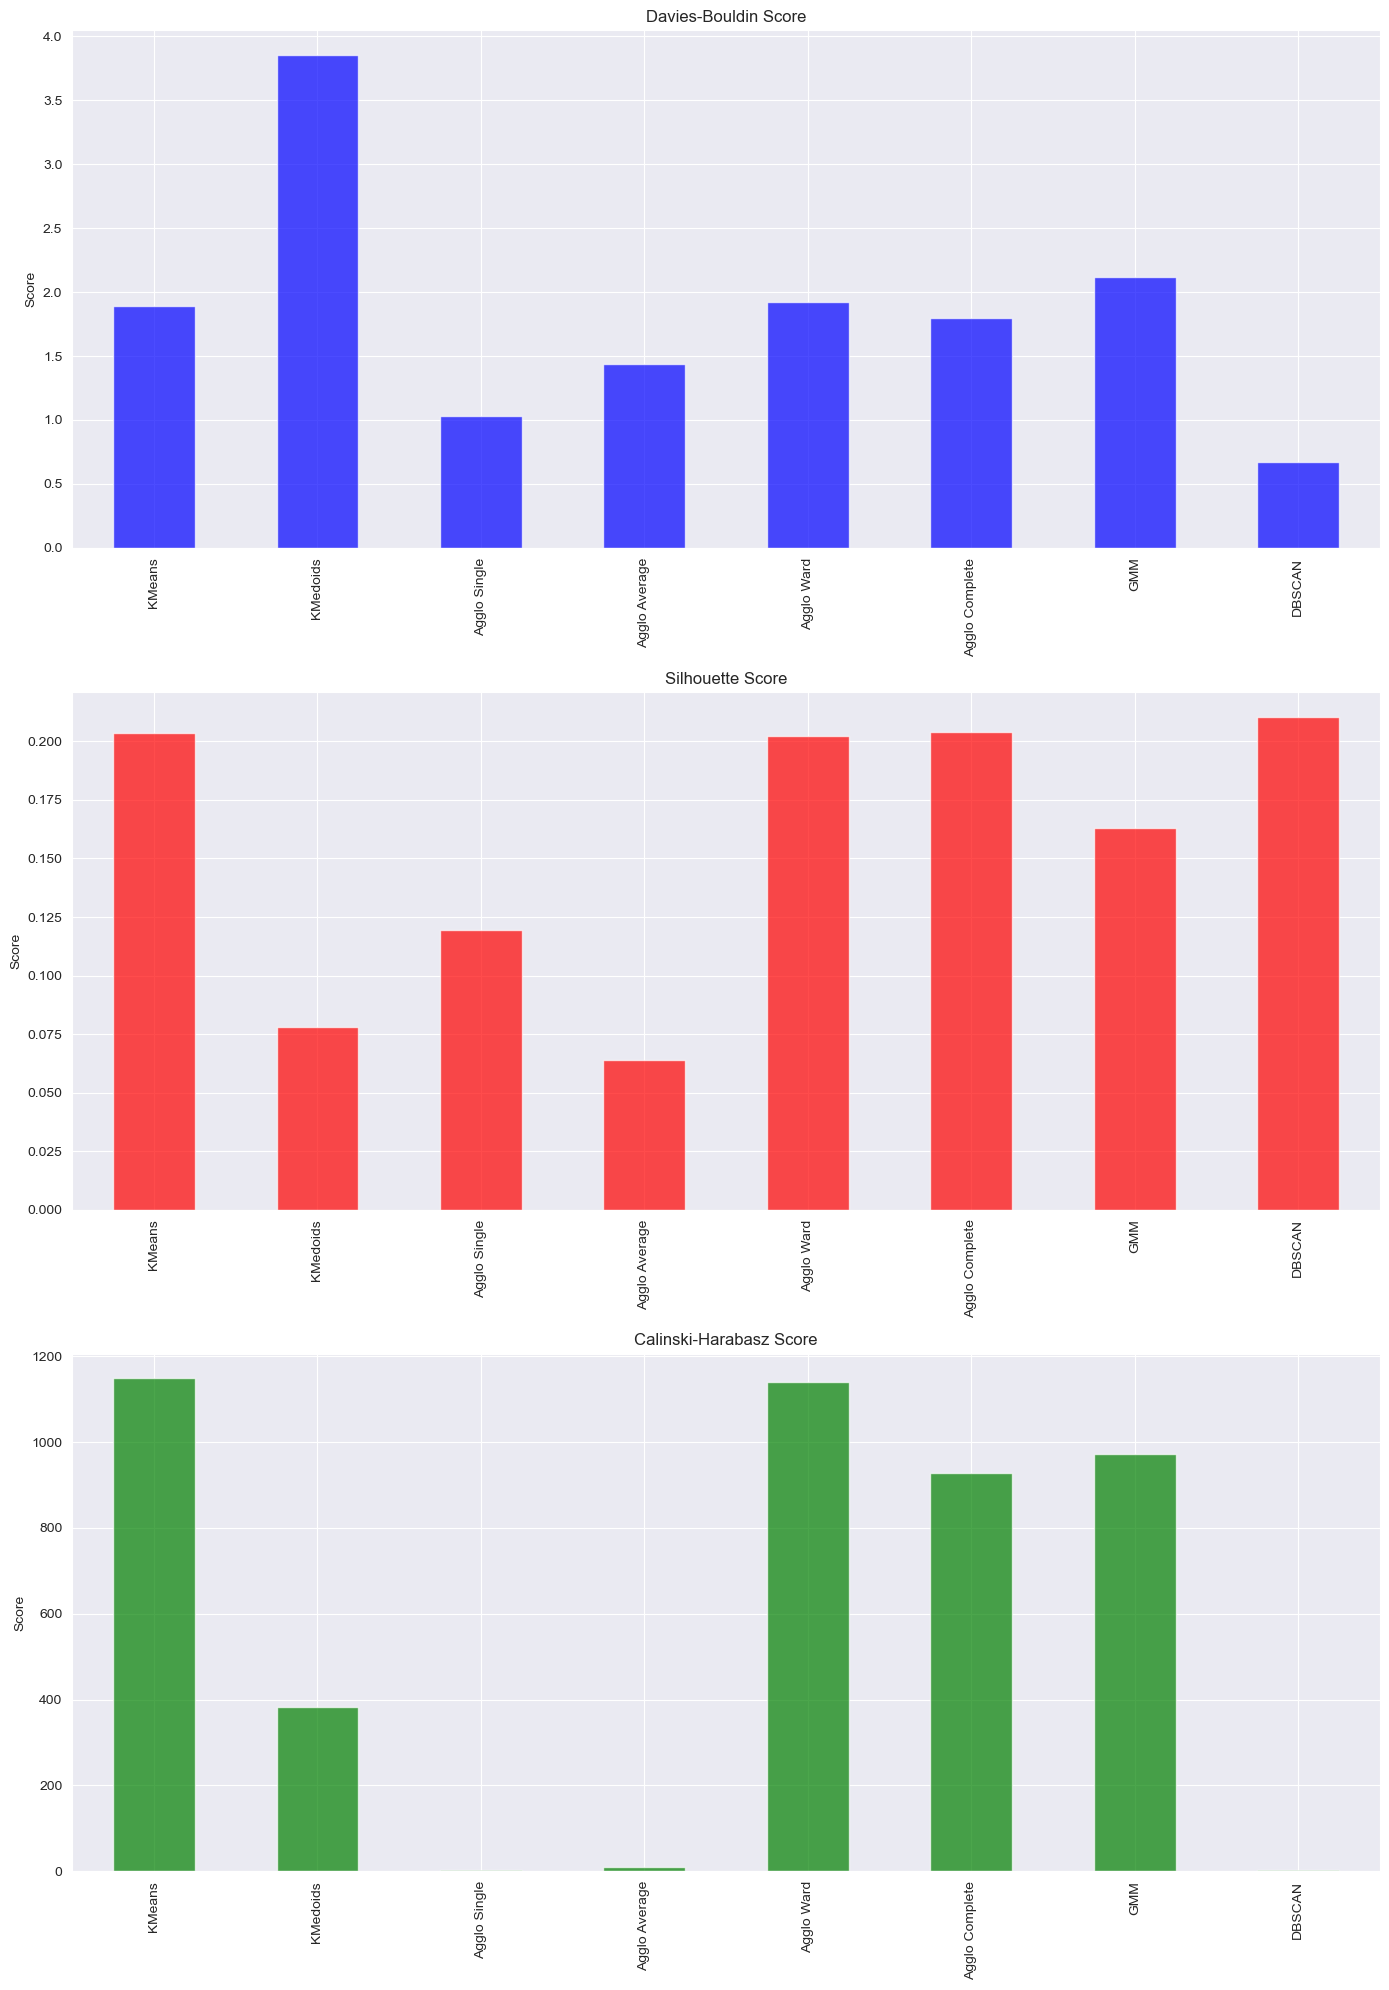

In [50]:
# Plot the results
fig, axs = plt.subplots(3, 1, figsize=(14, 20))

# Plot Davies-Bouldin Score
results_df['Davies-Bouldin Score'].plot(kind='bar', ax=axs[0], color='b', alpha=0.7)
axs[0].set_title('Davies-Bouldin Score')
axs[0].set_ylabel('Score')

# Plot Silhouette Score
results_df['Silhouette Score'].plot(kind='bar', ax=axs[1], color='r', alpha=0.7)
axs[1].set_title('Silhouette Score')
axs[1].set_ylabel('Score')

# Plot Calinski-Harabasz Score
results_df['Calinski-Harabasz Score'].plot(kind='bar', ax=axs[2], color='g', alpha=0.7)
axs[2].set_title('Calinski-Harabasz Score')
axs[2].set_ylabel('Score')

plt.tight_layout()
plt.show()


Davies-Bouldin - the lower the better
silhouette and calinski-harabasz - the higher the better

Our choice will be KMeans or Aggo ward. Let's make visualizations.